<a href="https://colab.research.google.com/github/JoshWuuu/AQI-analysis/blob/master/air_pollution_Josh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import time
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
import os
from calendar import monthrange
!pip install GeoPandas
import geopandas as gpd
from pandas.plotting import scatter_matrix
import datetime as dt

# weather, air, time filter

In [ ]:
path = '/content/drive/My Drive/air_polution/'
air_polution = pd.read_csv(path + 'Air pollution_new.csv', header = 0)
weather = pd.read_csv(path + 'Bangkok_weather_from_19850101.csv', header = 0)
wind = pd.read_csv(path + 'wind_2019.csv', header = 0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# converet number of the weather data into timestamp 
def getTime(t):
  return t[:4] + '-' + t[4:6] + '-' + t[6:8] + ' ' +t[9:11] + ':' + t[11:13] + ':00' 

In [ ]:
# clean weather data
weather.columns = weather.iloc[8]
weather = weather.drop([0,1,2,3,4,5,6,7,8], axis=0)
weather['timestamp'] = weather['timestamp'].apply(getTime)
weather

8,timestamp,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Snowfall Amount,Bangkok Cloud Cover Total,Bangkok Cloud Cover High [high cld lay],Bangkok Cloud Cover Medium [mid cld lay],Bangkok Cloud Cover Low [low cld lay],Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Direction [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Direction [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Direction [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Direction [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Direction [700 mb],Bangkok Wind Speed [500 mb],Bangkok Wind Direction [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m]
9,1985-01-01 00:00:00,20.825314,58.0,1012.7,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00144,0.030006643,0.0,22.68,6.1329885,357.51044,20.326454,22.932098,21.67487,48.366455,23.664352,56.793427,10.948973,80.537674,13.797912,97.49586,110.0,1517.0,3142.0,5846.0,25.62,15.03,8.76,20.06,25.110016,0.156,10.376534
10,1985-01-01 01:00:00,20.695314,58.0,1012.5,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02105972,0.0,14.4,4.861344,350.5377,13.324863,38.418045,13.896187,53.426956,13.479583,55.885513,8.4042845,80.134186,19.443333,88.93908,108.0,1517.0,3138.0,5848.0,25.55,14.86,8.69,18.54,23.080017,0.155,10.293839
11,1985-01-01 02:00:00,19.775314,60.0,1012.2,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018602137,0.0,14.759999,4.824709,353.65985,12.984975,46.123276,13.324863,51.58194,13.608762,52.52382,8.557102,75.37913,20.532627,92.009544,106.0,1513.0,3134.0,5844.0,24.78,14.81,8.7,18.09,22.49002,0.155,9.261869
12,1985-01-01 03:00:00,18.965315,62.0,1012.3,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01641783,0.0,15.119999,4.802594,356.8202,12.538134,50.82634,13.004922,48.366455,14.336861,51.115494,8.557102,67.75098,22.065973,95.61758,106.0,1512.0,3134.0,5844.0,24.13,14.8,8.76,17.45,21.920013,0.155,8.366398
13,1985-01-01 04:00:00,18.285315,64.0,1012.3,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012989098,0.0,14.4,4.5366287,356.63354,11.304229,52.76516,12.984975,43.876694,15.349684,50.71057,8.699793,65.55604,22.668568,100.060684,106.0,1510.0,3133.0,5843.0,23.49,14.84,8.86,16.98,21.380005,0.155,7.5959244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311068,2020-06-26 19:00:00,28.8153,77,1005.8,0,0,30,100,0,0,34.4284,23.14,16.4742,6.66576,0.0432,0.0455933,1459,14.04,6.1272,180,14.8694,186.953,11.7924,238.736,25.1537,279.058,9.51109,299.476,29.2687,121.931,52,1479,3125,5852,29.89,19.19,10.15,27.62,31.16,0.323,9.15358
311069,2020-06-26 20:00:00,28.1153,82,1006.6,0,0,30,100,2,0,0,0,0,0,0.01872,0.0127553,1530,13.68,6.1791,172.569,16.5756,177.51,11.967,248.839,24.7982,283.431,9.38765,302.471,29.3549,123.495,58,1485,3131,5856,29.41,19.21,9.96,27.38,30.61,0.323,6.87848
311070,2020-06-26 21:00:00,27.7253,85,1006.6,0,0,30,100,3,0,0,0,0,0,0.01872,0.00765578,1601,13.32,5.69498,169.216,17.3735,174.053,12.7279,261.87,25.0452,288.435,9.50427,307.304,29.5923,126.591,58,1484,3130,5855,28.97,19.23,9.86,27.12,30.16,0.322,5.60328
311071,2020-06-26 22:00:00,27.2553,88,1006.7,0,0,19.2,64,3,0,0,0,0,0,0.01296,0.00392373,1647,12.24,5.5626,163.301,17.1634,170.34,12.96,270,24.3446,293.532,9.44957,310.365,29.3637,130.525,59,1485,3130

In [ ]:
def transformWind (x, weather):
  new_windD = weather[x].astype(float)
  weather[x + '(sin)'] = np.sin(new_windD * np.pi / 180.)
  weather[x + '(cos)'] = np.cos(new_windD * np.pi / 180.)
  weather.drop(columns=[x], inplace=True)

In [ ]:
transformWind('Bangkok Wind Direction [10 m]', weather)
transformWind('Bangkok Wind Direction [80 m]', weather)
transformWind('Bangkok Wind Direction [900 mb]', weather)
transformWind('Bangkok Wind Direction [850 mb]', weather)
transformWind('Bangkok Wind Direction [700 mb]', weather)
transformWind('Bangkok Wind Direction [500 mb]', weather)

In [ ]:
weather

8,timestamp,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Snowfall Amount,Bangkok Cloud Cover Total,Bangkok Cloud Cover High [high cld lay],Bangkok Cloud Cover Medium [mid cld lay],Bangkok Cloud Cover Low [low cld lay],Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos)
9,1985-01-01 00:00:00,20.825314,58.0,1012.7,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00144,0.030006643,0.0,22.68,6.1329885,20.326454,21.67487,23.664352,10.948973,13.797912,110.0,1517.0,3142.0,5846.0,25.62,15.03,8.76,20.06,25.110016,0.156,10.376534,-4.343735e-02,0.999056,0.389640,0.920967,0.747409,6.643639e-01,0.836701,0.547659,0.986394,0.164399,0.991454,-0.130455
10,1985-01-01 01:00:00,20.695314,58.0,1012.5,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02105972,0.0,14.4,4.861344,13.324863,13.896187,13.479583,8.4042845,19.443333,108.0,1517.0,3138.0,5848.0,25.55,14.86,8.69,18.54,23.080017,0.155,10.293839,-1.643986e-01,0.986394,0.621395,0.783498,0.803098,5.958471e-01,0.827919,0.560848,0.985212,0.171341,0.999829,0.018515
11,1985-01-01 02:00:00,19.775314,60.0,1012.2,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018602137,0.0,14.759999,4.824709,12.984975,13.324863,13.608762,8.557102,20.532627,106.0,1513.0,3134.0,5844.0,24.78,14.81,8.7,18.09,22.49002,0.155,9.261869,-1.104308e-01,0.993884,0.720833,0.693109,0.783498,6.213948e-01,0.793606,0.608432,0.967617,0.252422,0.999385,-0.035066
12,1985-01-01 03:00:00,18.965315,62.0,1012.3,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01641783,0.0,15.119999,4.802594,12.538134,13.004922,14.336861,8.557102,22.065973,106.0,1512.0,3134.0,5844.0,24.13,14.8,8.76,17.45,21.920013,0.155,8.366398,-5.546949e-02,0.998460,0.775235,0.631673,0.747409,6.643639e-01,0.778413,0.627753,0.925547,0.378633,0.995197,-0.097888
13,1985-01-01 04:00:00,18.285315,64.0,1012.3,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012989098,0.0,14.4,4.5366287,11.304229,12.984975,15.349684,8.699793,22.668568,106.0,1510.0,3133.0,5843.0,23.49,14.84,8.86,16.98,21.380005,0.155,7.5959244,-5.872201e-02,0.998274,0.796162,0.605083,0.693109,7.208331e-01,0.773957,0.633238,0.910366,0.413803,0.984623,-0.174691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311068,2020-06-26 19:00:00,28.8153,77,1005.8,0,0,30,100,0,0,34.4284,23.14,16.4742,6.66576,0.0432,0.0455933,1459,14.04,6.1272,14.8694,11.7924,25.1537,9.51109,29.2687,52,1479,3125,5852,29.89,19.19,10.15,27.62,31.16,0.323,9.15358,1.224647e-16,-1.000000,-0.121054,-0.992646,-0.854788,-5.189781e-01,-0.987530,0.157432,-0.870563,0.492057,0.848689,-0.528893
311069,2020-06-26 20:00:00,28.1153,82,1006.6,0,0,30

In [ ]:
def filter_data(data, time):
  data.rename(columns={time: 'timestamp'},inplace=True)
  data.timestamp = pd.to_datetime(data['timestamp'])
  data = data.sort_values(["timestamp"])
  d1 = '2019-01-01' + ' 00:00:00'
  d2 = '2019-12-31' + ' 23:59:59'
  mask = (data['timestamp'] > pd.Timestamp(d1)) & (data['timestamp'] <= pd.Timestamp(d2))
  data = pd.DataFrame(data.loc[mask]).reset_index()
  return data

In [ ]:
ap_Dind = air_polution[air_polution['station'] == 'National Housing Authority Dindaeng']
ap_Dind =  filter_data(ap_Dind, 'date')
weather = filter_data(weather, 'time')
wind = filter_data(wind, 'local_time')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
ap_Dind

In [ ]:
weather

In [ ]:
wind

In [ ]:
data = pd.merge(ap_Dind,weather,how='inner',on='timestamp',validate='many_to_many')
data = pd.merge(data,wind,how='inner',on='timestamp',validate='many_to_many')

In [ ]:
data

# Traffic filter

In [ ]:
def clean_data(data, mon, lat_min, lat_max, lon_min, lon_max):
  data.timestamp = pd.to_datetime(data.timestamp, errors = 'coerce')
  data = data[data['engine_acc'] == 1]
  data = data[data['gpsvalid'] == 1]
  # data = data[data['timestamp'] != '2019-0101 00:00:00']
  data = data.drop(columns=['gpsvalid', 'engine_acc'])
  data = data[(data['lat'] <=  lat_max) & (lat_min <= data['lat'])]
  data = data[(data['lon'] <=  lon_max) & (lon_min <= data['lon'])]
  # data = data[data['timestamp'] != '2019-0101 00:00:00']
  data.timestamp = pd.to_datetime(data.timestamp)
  
  data = data.sort_values(["timestamp"])
  i = 1
  d1 = '2019-' + str(100+mon)[1:] + '-' + str(100+i)[1:] + ' 00:00:00'
  i = monthrange(2019, mon)[-1]
  d2 = '2019-' + str(100+mon)[1:] + '-' + str(100+i)[1:] + ' 23:59:59'
  mask = (data['timestamp'] > pd.Timestamp(d1)) & (data['timestamp'] <= pd.Timestamp(d2))
  data = pd.DataFrame(data.loc[mask])
  return data
# data = clean_data(data, mon)

In [ ]:
area = [[2,[13.742278, 13.772762, 100.518114, 100.582286]],
        [5,[13.718844, 13.798905, 100.502134, 100.594806]],
        [10,[13.673452, 13.8534, 100.454889, 100.641490]]]
def Extract_points_from_selected_district(mon, radius):
  for i in range(3):
    if (radius == area[i][0]):
      lat_min = area[i][1][0]
      lat_max = area[i][1][1]
      lon_min = area[i][1][2]
      lon_max = area[i][1][3]
  n_days = monthrange(2019, mon)[-1]
  comb = []
  for i in range(1,n_days + 1):
    if (mon == 7 and 16<i and i<22):
      continue
    print('working on'+ str(i))
    G_path = '/content/drive/My Drive/air_polution/PROBE-2019' + str(100+mon)[1:] + ' (1)/'
    file_path = G_path + '2019' + str(100+mon)[1:] +str(100 + i)[1:] + '.csv'
    data = pd.read_csv(file_path, header = None, names = ['VehicleID', 'gpsvalid', 'lat', 'lon', 'timestamp', 'speed', 'heading', 'for_hire_light', 'engine_acc'])
    # Remove invalid data points
    # print(data.timestamp)
    data = clean_data(data, mon)
    # convert Pandas into GeoPandas
    # gdf = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data.lon, data.lat))
    # # Extract points in selected district
    # print(data.lon.min,data.lon.max)
    # bk_dist_pt = gdf.cx[lat_min:lat_max, lon_min:lon_max]
    print()
    # out = pd.DataFrame(bk_dist_pt)
    comb.append(data)
    # print(out)
  out_comb = pd.concat(comb, axis=0)
  out_path = '/content/drive/My Drive/air_polution/filted' + str(100+mon)[1:] + '_' + str(radius) + 'km.csv'
  out_comb.to_csv(out_path, index = False)

In [ ]:
radiusss = [2, 5, 10]
months = [10, 11, 12]
for month in months:
  for i in radiusss:
    Extract_points_from_selected_district(month, i)

In [ ]:
def mergeMonth(start, end, distance):
  frames = []
  for i in range(end-start+1):
    file_path = '/content/drive/My Drive/air_polution/filted' + str(100+start)[1:] + '_' + str(distance) + 'km.csv'
    data = pd.read_csv(file_path)
    data.timestamp = pd.to_datetime(data.timestamp)
    data['timestamp'] = data['timestamp'].dt.floor('H')
    data = data.groupby('timestamp') \
           .agg({'speed':'mean', 'VehicleID':'size'}) \
           .rename(columns={'speed':'Avg_speed_'+str(distance)+'km','VehicleID':'num_cars_'+str(distance)+'km'}) \
           .reset_index()
    frames.append(data)
    start += 1
  data = pd.concat(frames)
  return data

In [ ]:
data_2km = mergeMonth(5, 12, 2)
data_5km = mergeMonth(5, 12, 5)
data_10km = mergeMonth(5, 12, 10)

In [ ]:
data = pd.merge(data_2km,data_5km,how='inner',on='timestamp',validate='many_to_many')
data = pd.merge(data,data_10km,how='inner',on='timestamp',validate='many_to_many')

In [ ]:
data = pd.merge(data,ap_Dind,how='inner',on='timestamp',validate='many_to_many')
data = pd.merge(data,weather,how='inner',on='timestamp',validate='many_to_many')
data = pd.merge(data,wind,how='inner',on='timestamp',validate='many_to_many')

In [ ]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,index_x,station,Latitude,Longitude,pm25,pm10,o3,no2,so2,co,aqi,index_y,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Snowfall Amount,Bangkok Cloud Cover Total,Bangkok Cloud Cover High [high cld lay],Bangkok Cloud Cover Medium [mid cld lay],Bangkok Cloud Cover Low [low cld lay],Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos),index,electricity,wind_speed
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,66923,National Housing Authority Dindaeng,13.762517,100.5502,76,50,2.8,12.1,-,0.1,76.0,300921,29.1853,75,1008.3,0,0,100,100,100,0,0,0,0,0,0,0.0365271,2049,13.68,9.32781,18.8442,16.9812,15.5302,6.92474,12.7686,73,1505,3160,5881,29.02,21.37,11.34,28.99,32.57,0.166,10.1646,2.855983e-02,-9.995921e-01,1.146240e-01,-9.934089e-01,-0.847998,-0.529999,-0.718602,-0.695421,0.155963,-0.987763,0.648466,0.761243,2880,0.014,2.857
1,2019-05-01 01:00:00,23.953872,4119,23.194452,11535,26.241387,27748,66922,National Housing Authority Dindaeng,13.762517,100.5502,61,42,2.8,11,-,0.1,61.0,300922,29.0653,76,1008.1,0,0,100,100,100,0,0,0,0,0,0.00144,0.034661,1991,13.68,9.32781,19.2457,18.0898,15.9135,6.84947,11.0901,72,1502,3155,5875,28.9,20.85,11,28.8,32.12,0.166,9.69063,2.855983e-02,-9.995921e-01,1.309384e-01,-9.913905e-01,-0.855732,-0.517419,-0.791782,-0.610803,0.052559,-0.998618,0.811534,0.584305,2881,0.006,2.475
2,2019-05-01 02:00:00,25.060471,3357,24.081961,9895,26.739299,23736,66921,National Housing Authority Dindaeng,13.762517,100.5502,63,41,2,11.6,-,0.1,63.0,300923,28.7153,77,1008.2,0,0,27,47,27,0,0,0,0,0,0,0.0324759,1876,14.04,9.324,19.2019,18.8476,16.4343,6.13058,10.0414,72,1501,3151,5870,28.75,20.23,10.56,28.18,31.69,0.166,9.10071,1.224647e-16,-1.000000e+00,1.124891e-01,-9.936530e-01,-0.878624,-0.477513,-0.876216,-0.481919,-0.058722,-0.998274,0.967997,0.250962,2882,0.003,2.166
3,2019-05-01 03:00:00,27.225277,2983,26.190077,8102,27.834251,21062,66920,National Housing Authority Dindaeng,13.762517,100.5502,55,40,2,12.1,-,0.1,55.0,300924,28.0753,79,1008.3,0,0,10,11,10,0,0,0,0,0,0,0.0283025,1703,13.32,9.32781,20.1729,20.1246,17.3175,4.10463,10.4957,73,1501,3147,5865,28.69,19.58,10.08,27.59,31.25,0.166,8.0062,-2.855983e-02,-9.995921e-01,3.569156e-02,-9.993629e-01,-0.894427,-0.447214,-0.935472,-0.353400,-0.263118,-0.964764,0.994692,-0.102899,2883,0.001,1.963
4,2019-05-01 04:00:00,28.938815,2566,28.346963,6799,29.361095,19247,66919,National Housing Authority Dindaeng,13.762517,100.5502,65,45,3.2,9.8,-,0.1,65.0,300925,27.5353,81,1008.1,0,0,1.2,4,0,0,0,0,0,0,0,0.0197899,1508,11.52,7.99644,19.44,20.1504,17.5184,2.30512,11.2698,71,1498,3143,5861,28.58,19.25,9.9,27.02,30.78,0.166,7.01915,-3

In [ ]:
out_path = '/content/drive/My Drive/air_polution/merge_May_Dec_all.csv'
data.to_csv(out_path, index = False)

In [ ]:
file_path_merge_May_Sep_5km = '/content/drive/My Drive/air_polution/merge_May_Dec_all.csv'
data = pd.read_csv(file_path_merge_May_Sep_5km)

In [ ]:
data = data.drop(columns={'station','Latitude','Longitude', 'pm25','pm10','o3','no2','so2','co','index_x', 'index_y', 'index', 'Bangkok Snowfall Amount'
, 'Bangkok Cloud Cover High [high cld lay]', 'Bangkok Cloud Cover Medium [mid cld lay]',	'Bangkok Cloud Cover Low [low cld lay]'}) 

In [ ]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),...,Bangkok Wind Direction [900 mb](sin)(past 3 hours average),Bangkok Wind Direction [900 mb](sin)(past 8 hours average),Bangkok Wind Direction [900 mb](sin)(past 24 hours average),Bangkok Wind Direction [900 mb](sin)(past 48 hours average),Bangkok Wind Direction [900 mb](cos)(past 3 hours average),Bangkok Wind Direction [900 mb](cos)(past 8 hours average),Bangkok Wind Direction [900 mb](cos)(past 24 hours average),Bangkok Wind Direction [900 mb](cos)(past 48 hours average),Bangkok Wind Direction [850 mb](sin)(past 3 hours average),Bangkok Wind Direction [850 mb](sin)(past 8 hours average),Bangkok Wind Direction [850 mb](sin)(past 24 hours average),Bangkok Wind Direction [850 mb](sin)(past 48 hours average),Bangkok Wind Direction [850 mb](cos)(past 3 hours average),Bangkok Wind Direction [850 mb](cos)(past 8 hours average),Bangkok Wind Direction [850 mb](cos)(past 24 hours average),Bangkok Wind Direction [850 mb](cos)(past 48 hours average),Bangkok Wind Direction [700 mb](sin)(past 3 hours average),Bangkok Wind Direction [700 mb](sin)(past 8 hours average),Bangkok Wind Direction [700 mb](sin)(past 24 hours average),Bangkok Wind Direction [700 mb](sin)(past 48 hours average),Bangkok Wind Direction [700 mb](cos)(past 3 hours average),Bangkok Wind Direction [700 mb](cos)(past 8 hours average),Bangkok Wind Direction [700 mb](cos)(past 24 hours average),Bangkok Wind Direction [700 mb](cos)(past 48 hours average),Bangkok Wind Direction [500 mb](sin)(past 3 hours average),Bangkok Wind Direction [500 mb](sin)(past 8 hours average),Bangkok Wind Direction [500 mb](sin)(past 24 hours average),Bangkok Wind Direction [500 mb](sin)(past 48 hours average),Bangkok Wind Direction [500 mb](cos)(past 3 hours average),Bangkok Wind Direction [500 mb](cos)(past 8 hours average),Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average)
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,76.0,29.185314,75.0,1008.3,0.0,100.0,0.000000,0.0,0.0,0.0,0.00000,0.036527,2049.0,13.679999,9.327805,18.844202,16.981165,15.530151,6.924738,12.768586,73.0,1505.0,3160.0,5881.0,29.02,21.37,11.34,28.99,32.570007,0.166,10.164595,2.855983e-02,-9.995921e-01,...,-0.847998,-0.847998,-0.847998,-0.847998,-0.529999,-0.529999,-0.529999,-0.529999,-0.718602,-0.718602,-0.718602,-0.718602,-0.695421,-0.695421,-0.695421,-0.695421,0.155963,0.155963,0.155963,0.155963,-0.987763,-0.987763,-0.987763,-0.987763,0.648466,0.648466,0.648466,0.648466,0.761243,0.761243,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000

In [ ]:
def incoporateHistoric (colName, H, df):
  for i in range(len(df)):
    result = 0;
    # let the first few row run at first
    if (i <= H):
      if (i == 0):
        df.loc[df.index[i], colName + '(past %s hours average)' % (H)] = df.loc[df.index[i],colName]
      else:
        for k in range(i):
          row_data = float(df.loc[df.index[k],colName])
          result += row_data
        df.loc[df.index[i], colName + '(past %s hours average)' % (H)] = result / i
      continue
    
    for j in range(H):
      row_data = float(df.loc[df.index[i-j],colName])
      result += row_data
    df.loc[df.index[i], colName + '(past %s hours average)' % (H)] = result / H

In [ ]:
cols = data.columns
for col in cols:
  if (col == 'timestamp'):
    continue
  incoporateHistoric(col, 3, data)
  incoporateHistoric(col, 8, data)
  incoporateHistoric(col, 24, data)
  incoporateHistoric(col, 48, data)

In [ ]:
out_path = '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic.csv'
data.to_csv(out_path, index = False)

# Time filter

In [ ]:
file_path_merge_May_Sep_5km = '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic.csv'
data = pd.read_csv(file_path_merge_May_Sep_5km)

In [ ]:
def timeFilter(df):
  r = 0
  data.timestamp = pd.to_datetime(data.timestamp)
  for i in range(len(df)):
    hour = df.loc[df.index[i],'timestamp'].hour
    date = df.loc[df.index[i],'timestamp'].day
    month = df.loc[df.index[i],'timestamp'].month
    day = df.loc[df.index[i],'timestamp'].dayofweek
    df.loc[df.index[i], 'hour of the day (sin)'] = np.sin(hour * 15 * np.pi / 180.)
    df.loc[df.index[i], 'hour of the day (cos)'] = np.cos(hour * 15 * np.pi / 180.)

    if (hour <= 16 and hour >= 6):
      df.loc[df.index[i], 'part of the day(0 = day time, 1 = night time)'] = 0
    else:
      df.loc[df.index[i], 'part of the day(0 = day time, 1 = night time)'] = 1

    if (month >= 3 and month <= 6):
      df.loc[df.index[i], 'season (0 = hot, 1 = rain, 2 = cool)'] = 0
    elif (month >=7 and month <= 10):
      df.loc[df.index[i], 'season (0 = hot, 1 = rain, 2 = cool)'] = 1
    else:
      df.loc[df.index[i], 'season (0 = hot, 1 = rain, 2 = cool)'] = 2
    
    # mark national holiday first
    if (((month == 1) and (date == 1)) or ((month == 2) and (date == 19)) or ((month == 4) and (date == 8)) or ((month == 4) and (date == 13)) or ((month == 4) and (date == 14)) or ((month == 4) and (date == 15)) or ((month == 4) and (date == 16))
        or ((month == 5) and (date == 1)) or ((month == 5) and (date == 6)) or ((month == 5) and (date == 20)) or ((month == 6) and (date == 3)) or ((month == 7) and (date == 16)) or ((month == 7) and (date == 29)) or ((month == 8) and (date == 12)) 
        or ((month == 10) and (date == 14)) or ((month == 10) and (date == 23)) or ((month == 12) and (date == 5)) or ((month == 12) and (date == 10)) or ((month == 12) and (date == 30))):
      df.loc[df.index[i], 'type of day (0 = workday, 1 = weekend, 2 = national holiday)'] = 2
    elif (day<=4):
      df.loc[df.index[i], 'type of day (0 = workday, 1 = weekend, 2 = national holiday)'] = 0
    else:
      df.loc[df.index[i], 'type of day (0 = workday, 1 = weekend, 2 = national holiday)'] = 1 
    

In [ ]:
timeFilter(data)

In [ ]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),...,Bangkok Wind Direction [900 mb](cos)(past 8 hours average),Bangkok Wind Direction [900 mb](cos)(past 24 hours average),Bangkok Wind Direction [900 mb](cos)(past 48 hours average),Bangkok Wind Direction [850 mb](sin)(past 3 hours average),Bangkok Wind Direction [850 mb](sin)(past 8 hours average),Bangkok Wind Direction [850 mb](sin)(past 24 hours average),Bangkok Wind Direction [850 mb](sin)(past 48 hours average),Bangkok Wind Direction [850 mb](cos)(past 3 hours average),Bangkok Wind Direction [850 mb](cos)(past 8 hours average),Bangkok Wind Direction [850 mb](cos)(past 24 hours average),Bangkok Wind Direction [850 mb](cos)(past 48 hours average),Bangkok Wind Direction [700 mb](sin)(past 3 hours average),Bangkok Wind Direction [700 mb](sin)(past 8 hours average),Bangkok Wind Direction [700 mb](sin)(past 24 hours average),Bangkok Wind Direction [700 mb](sin)(past 48 hours average),Bangkok Wind Direction [700 mb](cos)(past 3 hours average),Bangkok Wind Direction [700 mb](cos)(past 8 hours average),Bangkok Wind Direction [700 mb](cos)(past 24 hours average),Bangkok Wind Direction [700 mb](cos)(past 48 hours average),Bangkok Wind Direction [500 mb](sin)(past 3 hours average),Bangkok Wind Direction [500 mb](sin)(past 8 hours average),Bangkok Wind Direction [500 mb](sin)(past 24 hours average),Bangkok Wind Direction [500 mb](sin)(past 48 hours average),Bangkok Wind Direction [500 mb](cos)(past 3 hours average),Bangkok Wind Direction [500 mb](cos)(past 8 hours average),Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average),hour of the day (sin),hour of the day (cos),"part of the day(0 = day time, 1 = night time)","season (0 = hot, 1 = rain, 2 = cool)","type of day (0 = workday, 1 = weekend, 2 = national holiday)"
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,76.0,29.185314,75.0,1008.3,0.0,100.0,0.000000,0.0,0.0,0.0,0.00000,0.036527,2049.0,13.679999,9.327805,18.844202,16.981165,15.530151,6.924738,12.768586,73.0,1505.0,3160.0,5881.0,29.02,21.37,11.34,28.99,32.570007,0.166,10.164595,2.855983e-02,-9.995921e-01,...,-0.529999,-0.529999,-0.529999,-0.718602,-0.718602,-0.718602,-0.718602,-0.695421,-0.695421,-0.695421,-0.695421,0.155963,0.155963,0.155963,0.155963,-0.987763,-0.987763,-0.987763,-0.987763,0.648466,0.648466,0.648466,0.648466,0.761243,0.761243,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000,2.857000,0.000000,1.000000,1.0,0.0,2.0
1,2019-05-01 01:00:00,23.953872,4119,23.194452,11535,26.241387,27748,61.0,29.065313,76.0,1008.1,0.0,100.0,0.00000



#   aqi filter


In [ ]:
# drop outliers
upperbound = data.aqi.mean(axis = 0) + 3 * data.aqi.std(axis = 0)
lowerbound = data.aqi.mean(axis = 0) - 3 * data.aqi.std(axis = 0)
data.drop(data[data['aqi'] > upperbound].index, inplace = True) 
data.drop(data[data['aqi'] < lowerbound].index, inplace = True) 

In [ ]:
incoporateHistoric('aqi', 3, data)
incoporateHistoric('aqi', 8, data)
incoporateHistoric('aqi', 24, data)
incoporateHistoric('aqi', 48, data)
incoporateHistoric('aqi', 168, data)

In [ ]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),...,Bangkok Wind Direction [900 mb](cos)(past 24 hours average),Bangkok Wind Direction [900 mb](cos)(past 48 hours average),Bangkok Wind Direction [850 mb](sin)(past 3 hours average),Bangkok Wind Direction [850 mb](sin)(past 8 hours average),Bangkok Wind Direction [850 mb](sin)(past 24 hours average),Bangkok Wind Direction [850 mb](sin)(past 48 hours average),Bangkok Wind Direction [850 mb](cos)(past 3 hours average),Bangkok Wind Direction [850 mb](cos)(past 8 hours average),Bangkok Wind Direction [850 mb](cos)(past 24 hours average),Bangkok Wind Direction [850 mb](cos)(past 48 hours average),Bangkok Wind Direction [700 mb](sin)(past 3 hours average),Bangkok Wind Direction [700 mb](sin)(past 8 hours average),Bangkok Wind Direction [700 mb](sin)(past 24 hours average),Bangkok Wind Direction [700 mb](sin)(past 48 hours average),Bangkok Wind Direction [700 mb](cos)(past 3 hours average),Bangkok Wind Direction [700 mb](cos)(past 8 hours average),Bangkok Wind Direction [700 mb](cos)(past 24 hours average),Bangkok Wind Direction [700 mb](cos)(past 48 hours average),Bangkok Wind Direction [500 mb](sin)(past 3 hours average),Bangkok Wind Direction [500 mb](sin)(past 8 hours average),Bangkok Wind Direction [500 mb](sin)(past 24 hours average),Bangkok Wind Direction [500 mb](sin)(past 48 hours average),Bangkok Wind Direction [500 mb](cos)(past 3 hours average),Bangkok Wind Direction [500 mb](cos)(past 8 hours average),Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average),hour of the day (sin),hour of the day (cos),"part of the day(0 = day time, 1 = night time)","season (0 = hot, 1 = rain, 2 = cool)","type of day (0 = workday, 1 = weekend, 2 = national holiday)",aqi(past 168 hours average)
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,76.0,29.185314,75.0,1008.3,0.0,100.0,0.000000,0.0,0.0,0.0,0.00000,0.036527,2049.0,13.679999,9.327805,18.844202,16.981165,15.530151,6.924738,12.768586,73.0,1505.0,3160.0,5881.0,29.02,21.37,11.34,28.99,32.570007,0.166,10.164595,2.855983e-02,-9.995921e-01,...,-0.529999,-0.529999,-0.718602,-0.718602,-0.718602,-0.718602,-0.695421,-0.695421,-0.695421,-0.695421,0.155963,0.155963,0.155963,0.155963,-0.987763,-0.987763,-0.987763,-0.987763,0.648466,0.648466,0.648466,0.648466,0.761243,0.761243,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000,2.857000,0.000000,1.000000,1.0,0.0,2.0,76.000000
1,2019-05-01 01:00:00,23.953872,4119,23.194452,11535,26.241387,27748,61.0,29.065313,76.0,1008.1,0.0,100.0,0.000000,0.0,0.0,0.0,0.00144,0.034661,

In [ ]:
out_path = '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic_aqiTime.csv'
data.to_csv(out_path, index = False)

# Data cleaning

In [ ]:
file_path_merge_May_Sep_5km =  '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic_aqiTime.csv'
data = pd.read_csv(file_path_merge_May_Sep_5km)

In [ ]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),...,Bangkok Wind Direction [900 mb](cos)(past 24 hours average),Bangkok Wind Direction [900 mb](cos)(past 48 hours average),Bangkok Wind Direction [850 mb](sin)(past 3 hours average),Bangkok Wind Direction [850 mb](sin)(past 8 hours average),Bangkok Wind Direction [850 mb](sin)(past 24 hours average),Bangkok Wind Direction [850 mb](sin)(past 48 hours average),Bangkok Wind Direction [850 mb](cos)(past 3 hours average),Bangkok Wind Direction [850 mb](cos)(past 8 hours average),Bangkok Wind Direction [850 mb](cos)(past 24 hours average),Bangkok Wind Direction [850 mb](cos)(past 48 hours average),Bangkok Wind Direction [700 mb](sin)(past 3 hours average),Bangkok Wind Direction [700 mb](sin)(past 8 hours average),Bangkok Wind Direction [700 mb](sin)(past 24 hours average),Bangkok Wind Direction [700 mb](sin)(past 48 hours average),Bangkok Wind Direction [700 mb](cos)(past 3 hours average),Bangkok Wind Direction [700 mb](cos)(past 8 hours average),Bangkok Wind Direction [700 mb](cos)(past 24 hours average),Bangkok Wind Direction [700 mb](cos)(past 48 hours average),Bangkok Wind Direction [500 mb](sin)(past 3 hours average),Bangkok Wind Direction [500 mb](sin)(past 8 hours average),Bangkok Wind Direction [500 mb](sin)(past 24 hours average),Bangkok Wind Direction [500 mb](sin)(past 48 hours average),Bangkok Wind Direction [500 mb](cos)(past 3 hours average),Bangkok Wind Direction [500 mb](cos)(past 8 hours average),Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average),hour of the day (sin),hour of the day (cos),"part of the day(0 = day time, 1 = night time)","season (0 = hot, 1 = rain, 2 = cool)","type of day (0 = workday, 1 = weekend, 2 = national holiday)",aqi(past 168 hours average)
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,76.0,29.185314,75.0,1008.3,0.0,100.0,0.000000,0.0,0.0,0.0,0.00000,0.036527,2049.0,13.679999,9.327805,18.844202,16.981165,15.530151,6.924738,12.768586,73.0,1505.0,3160.0,5881.0,29.02,21.37,11.34,28.99,32.570007,0.166,10.164595,2.855983e-02,-9.995921e-01,...,-0.529999,-0.529999,-0.718602,-0.718602,-0.718602,-0.718602,-0.695421,-0.695421,-0.695421,-0.695421,0.155963,0.155963,0.155963,0.155963,-0.987763,-0.987763,-0.987763,-0.987763,0.648466,0.648466,0.648466,0.648466,0.761243,0.761243,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000,2.857000,0.000000,1.000000,1.0,0.0,2.0,76.000000
1,2019-05-01 01:00:00,23.953872,4119,23.194452,11535,26.241387,27748,61.0,29.065313,76.0,1008.1,0.0,100.0,0.000000,0.0,0.0,0.0,0.00144,0.034661,

In [ ]:
X = data.drop(columns={'timestamp','Avg_speed_2km', 'num_cars_2km', 'Avg_speed_5km', 'num_cars_5km', 'Avg_speed_10km', 'num_cars_10km'})
Y1 = data.loc[:, 'Avg_speed_2km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y2 = data.loc[:, 'num_cars_2km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y3 = data.loc[:, 'Avg_speed_5km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y4 = data.loc[:, 'num_cars_5km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y5 = data.loc[:, 'Avg_speed_10km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y6 = data.loc[:, 'num_cars_10km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [ ]:
X = X.iloc[:, [ 1, 2, 3, 4, 5, 7, 13, 14, 17, 26, 35, 36, 51, 55, 58, 59, 63, 66, 70, 71, 74, 75, 76, 83, 98, 99, 102, 106, 110, 111, 114, 119, 126, 127, 128, 130, 131, 135, 162, 171, 186, 187, 194, 195, 198, 202, 204, 205, 246, 251, 254, 255]]

In [ ]:
importantFeature = [ 1, 2, 3, 4, 5, 13, 14, 15, 19, 20, 28, 32, 35, 36, 37, 39, 40, 41, 43, 46, 47, 50, 51, 55, 59, 60, 63, 66, 67, 70, 71, 72, 74, 75, 77, 79, 83, 98, 103, 106, 110, 111, 114, 115, 117, 123, 124, 129, 130, 131, 134, 135, 150, 163, 167, 179, 194, 198, 200, 202, 203, 205, 207, 209, 214, 216, 217, 219, 227, 229, 230, 231, 232, 240, 250, 251, 254, 255]
features = []
for i in importantFeature:
  features.append(X.columns[i])
print(features) 
# distance = [2, 3.5, 5, 7.5, 10, 12.5]
# for i in distance:
#   file_path_merge_May_Sep_5km = '/content/drive/My Drive/air_polution/X_' + str(i) +'km.csv'
#   data = pd.read_csv(file_path_merge_May_Sep_5km)
#   print(data.mean(axis = 0))

['num_cars_2km', 'Avg_speed_5km', 'num_cars_5km', 'Avg_speed_10km', 'num_cars_10km', 'Bangkok Direct Shortwave Radiation', 'Bangkok Diffuse Shortwave Radiation', 'Bangkok Evapotranspiration', 'Bangkok Wind Speed [10 m]', 'Bangkok Wind Speed [80 m]', 'Bangkok Geopotential Height [500 mb]', 'Bangkok Temperature', 'Bangkok Vapor Pressure Deficit [2 m]', 'Bangkok Wind Direction [10 m](sin)', 'Bangkok Wind Direction [10 m](cos)', 'Bangkok Wind Direction [80 m](cos)', 'Bangkok Wind Direction [900 mb](sin)', 'Bangkok Wind Direction [900 mb](cos)', 'Bangkok Wind Direction [850 mb](cos)', 'Bangkok Wind Direction [500 mb](sin)', 'Bangkok Wind Direction [500 mb](cos)', 'Avg_speed_2km(past 3 hours average)', 'Avg_speed_2km(past 8 hours average)', 'num_cars_2km(past 8 hours average)', 'Avg_speed_5km(past 8 hours average)', 'Avg_speed_5km(past 24 hours average)', 'num_cars_5km(past 8 hours average)', 'Avg_speed_10km(past 3 hours average)', 'Avg_speed_10km(past 8 hours average)', 'num_cars_10km(past 

In [ ]:
(32, 0.5682968), (40, 0.020441227), (76, 0.01966464), (42, 0.015477915), (77, 0.014487961), (34, 0.013248229), (39, 0.013142241), (41, 0.009419279), (22, 0.008728121), (0, 0.008267234), (4, 0.0076603107), (33, 0.0075767166), (2, 0.007406694), (30, 0.0068728155), (23, 0.0067997403), (75, 0.0067215054), (37, 0.0063957423), (28, 0.0063749836), (6, 0.006324271), (26, 0.005804517), (3, 0.005666649), (13, 0.0055517647), (27, 0.005520077), (5, 0.005500258), (24, 0.0053454703), (12, 0.005325301), (51, 0.0050762896), (29, 0.0050424924), (66, 0.0049862317), (74, 0.0049481285), (46, 0.004796532), (48, 0.0047496203), (1, 0.0047171544), (65, 0.0046278597), (60, 0.0045767287), (57, 0.004576476), (50, 0.004543843), (49, 0.0045069535), (67, 0.0044961628), (36, 0.0044940864), (14, 0.004394157), (21, 0.00438025), (43, 0.0043777367), (56, 0.004357246), (38, 0.0042899917), (7, 0.004244704), (25, 0.0041923756), (11, 0.0041104197), (16, 0.004068573), (47, 0.004034943), (59, 0.0040069376), (17, 0.0039844965), (9, 0.003955304), (35, 0.0039326167), (19, 0.003810384), (70, 0.0038048862), (54, 0.0037890705), (10, 0.0037821855), (45, 0.0037819236), (8, 0.003749973), (31, 0.0037309271), (71, 0.003721492), (62, 0.0036917832), (58, 0.0036688312), (72, 0.0035573498), (69, 0.003510689), (63, 0.0034906748), (61, 0.0034232456), (64, 0.003406331), (55, 0.0033684156), (18, 0.0033378508), (68, 0.0032432086), (53, 0.0032055113), (52, 0.0031613573), (44, 0.0031377368), (15, 0.0031123313), (20, 0.0030686837), (73, 0.0029564386)]

In [ ]:
importantFeature_model = [32, 40, 76, 42, 77, 34, 39, 41, 22, 0, 4, 33, 2, 30, 23, 75]
features_selected = []
for i in importantFeature_model:
  features_selected.append(features[i])
print(features_selected) 

['aqi(past 3 hours average)', 'Bangkok Diffuse Shortwave Radiation(past 3 hours average)', 'hour of the day (sin)', 'Bangkok Evapotranspiration(past 3 hours average)', 'hour of the day (cos)', 'aqi(past 48 hours average)', 'Bangkok Direct Shortwave Radiation(past 3 hours average)', 'Bangkok Diffuse Shortwave Radiation(past 8 hours average)', 'Avg_speed_2km(past 8 hours average)', 'num_cars_2km', 'num_cars_10km', 'aqi(past 8 hours average)', 'num_cars_5km', 'num_cars_10km(past 8 hours average)', 'num_cars_2km(past 8 hours average)', 'wind_speed(past 8 hours average)']


In [ ]:
# fig, axs = plt.subplots(5, 8, squeeze=False)
# for i in range(len(X.columns)):
#   axs[int(i/8),i%8].scatter(X.iloc[:,i],Y)
#   axs[int(i/8),i%8].set_title(X.columns[i])
import seaborn as sns; sns.set(color_codes=True)
plot_features = ['aqi(past 3 hours average)', 'aqi(past 8 hours average)', 'aqi(past 24 hours average)', 'Bangkok Diffuse Shortwave Radiation(past 3 hours average)'
, 'Bangkok Geopotential Height [850 mb]', 'Bangkok Direct Shortwave Radiation(past 3 hours average)', 'num_cars_2km',
'Avg_speed_5km', 'Bangkok Evapotranspiration(past 3 hours average)']
for i in range(len(X.columns)):
  if X.columns[i] in plot_features:
    ax = sns.regplot(x=X.loc[:,'aqi(past 3 hours average)'], y=np.log(Y), line_kws={"color":"r","alpha":0.7,"lw":5})

SyntaxError: ignored

In [ ]:
Y = np.log(Y)

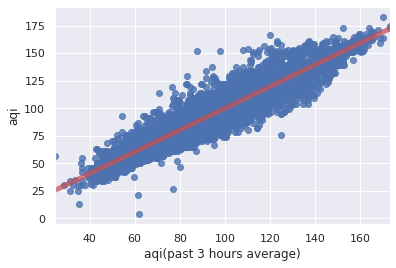

In [ ]:
ax = sns.regplot(x=X.loc[:,'aqi(past 3 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

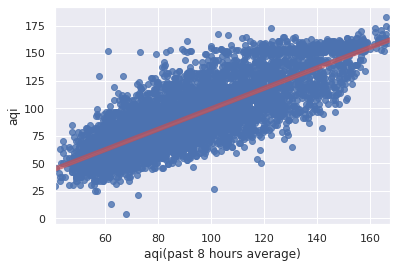

In [ ]:
ax = sns.regplot(x=X.loc[:,'aqi(past 8 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

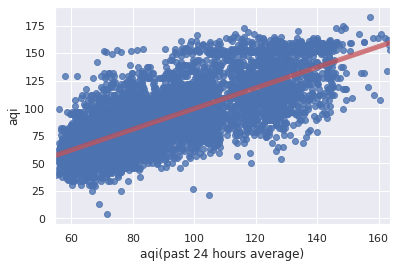

In [ ]:
ax = sns.regplot(x=X.loc[:,'aqi(past 24 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

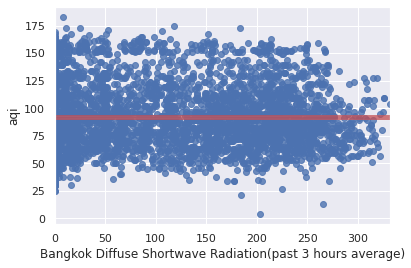

In [ ]:
ax = sns.regplot(x=X.loc[:,'Bangkok Diffuse Shortwave Radiation(past 3 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

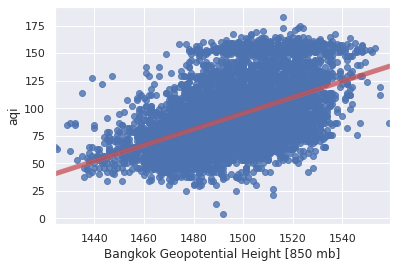

In [ ]:
ax = sns.regplot(x=X.loc[:,'Bangkok Geopotential Height [850 mb]'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

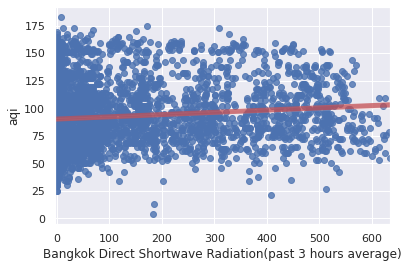

In [ ]:
ax = sns.regplot(x=X.loc[:,'Bangkok Direct Shortwave Radiation(past 3 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

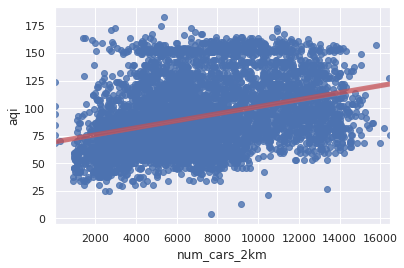

In [ ]:
ax = sns.regplot(x=X.loc[:,'num_cars_2km'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

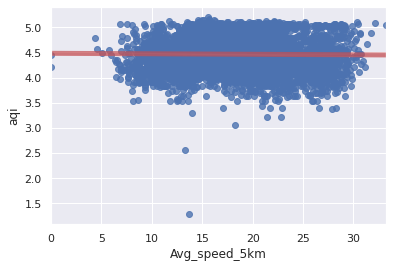

In [ ]:
 ax = sns.regplot(x=X.loc[:,'Avg_speed_5km'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

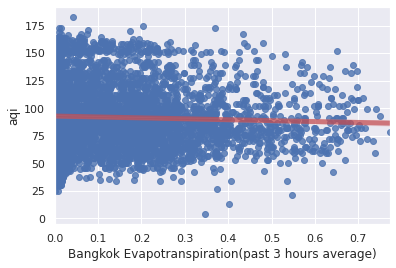

In [ ]:
 ax = sns.regplot(x=X.loc[:,'Bangkok Evapotranspiration(past 3 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
# file_path_merge_May_Sep_5km = '/content/drive/My Drive/air_polution/merge_May_Sep_5km.csv'
# data = pd.read_csv(file_path_merge_May_Sep_5km)
# X = data.drop(columns={'timestamp','station','Latitude','Longitude', 'pm25','pm10','o3','no2','so2','co','aqi','index_x', 'index_y', 'index', 'Bangkok Snowfall Amount'
# , 'Bangkok Cloud Cover High [high cld lay]', 'Bangkok Cloud Cover Medium [mid cld lay]',	'Bangkok Cloud Cover Low [low cld lay]'}) 
# 'Bangkok Temperature [2 m elevation corrected]', 
# 'Bangkok Relative Humidity [2 m]', 'Bangkok Mean Sea Level Pressure [MSL]', 'Bangkok Precipitation Total', 'Bangkok Cloud Cover Total', 'Bangkok Sunshine Duration', 
# 'Bangkok Shortwave Radiation', 'Bangkok Direct Shortwave Radiation', 'Bangkok Diffuse Shortwave Radiation', 'Bangkok Evapotranspiration', 'Bangkok FAO Reference Evapotranspiration [2 m]', 
# 'Bangkok CAPE [180-0 mb above gnd]', 'Bangkok Wind Gust', 'Bangkok Wind Speed [10 m]', 'Bangkok Wind Direction [10 m]', 'Bangkok Wind Speed [80 m]', 'Bangkok Wind Direction [80 m]', 
# 'Bangkok Wind Direction [900 mb]', 'Bangkok Wind Speed [500 mb]', 'Bangkok Geopotential Height [1000 mb]', 'Bangkok Geopotential Height [700 mb]', 'Bangkok Geopotential Height [500 mb]', 
# 'Bangkok Temperature [1000 mb]', 'Bangkok Temperature [700 mb]', 'Bangkok Soil Temperature [0-10 cm down]', 'Bangkok Vapor Pressure Deficit [2 m]', 'electricity', 'wind_speed'})
# Y = data.loc[:, 'aqi'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
# out_path = '/content/drive/My Drive/air_polution/X_5km.csv'
# X.to_csv(out_path, index = True)

scaler = StandardScaler().fit(X)
X = scaler.fit_transform(X)
# Y = np.log(Y)
# Y = np.ravel(Y)
# split the train set into training data and validation data
# X_train, X_val, y_train, y_val = train_test_split(
#     X, Y, train_size=0.75
# )
# y_train = np.ravel(y_train)
# y_val = np.ravel(y_val)

# Feature selection

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.decomposition import KernelPCA
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
import xgboost as xgb

In [ ]:
# determine which feature selection select the best set of parameters with best accuracy
estimator = GradientBoostingRegressor(max_depth=8)
clf = Pipeline([
  ('feature_selection', RFE(estimator, n_features_to_select=150, step=0.05)),
  ('regression', GradientBoostingRegressor(max_depth=8))
])

In [ ]:
# k fold split
feature_selection = cross_validate(clf, X, Y, cv=10, scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (feature_selection['test_score'].mean(), feature_selection['test_score'].std() * 2))
clf['feature_selection'].n_features_
clf['feature_selection'].ranking_

Accuracy: 0.80 (+/- 0.13)


AttributeError: ignored

In [ ]:
a = selector.ranking_
idx = [a[i] for i in np.where(a == 1)]
print(idx)
print(np.where(a == 1))

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
(array([  0,   1,   2,   3,   4,   5,  12,  13,  14,  15,  16,  17,  19,
        20,  21,  23,  24,  25,  26,  27,  30,  32,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  45,  46,  47,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  62,  63,  66,  67,  68,  70,  71,
        74,  75,  76,  77,  78,  79,  83,  87,  98, 103, 106, 107, 110,
       111, 113, 114, 116, 117, 118, 119, 122, 123, 124, 127, 130, 131,
       133, 134, 135, 136, 137, 142, 147, 149, 150, 157, 162, 163, 165,
       166, 167, 171, 175, 178, 179, 186, 187, 194, 198, 202

In [ ]:
# time series split
tscv = TimeSeriesSplit(n_splits=10)
scores = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf.fit(X_train, y_train)
     scores.append(clf.score(X_test, y_test))
print(scores.mean())

In [ ]:
# dimension reduction
# PCA
transformer = KernelPCA(n_components=7, kernel='rbf')
X_transformed = transformer.fit_transform(X)

In [ ]:
# wrapper
# RFECV
xgb_model = xgb.XGBRegressor(max_depth=3, objective= 'reg:squarederror', booster= 'gbtree', n_estimators=300, learning_rate= 0.1, subsample= 0.9, min_child_weight= 10, colsample_bytree= 0.8)
selector = RFECV(xgb_model, step=0.05, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), min_features_to_select = 50)
selector = selector.fit(X, Y)

In [ ]:
selector.n_features_
a = selector.ranking_
# selector.grid_scores_.std()
# Reduce X to the selected features.
X = selector.transform(X)

In [ ]:
index = np.where(a == 1)
print(index)

(array([  1,   2,   3,   4,   5,   7,  13,  14,  17,  26,  35,  36,  51,
        55,  58,  59,  63,  66,  70,  71,  74,  75,  76,  83,  98,  99,
       102, 106, 110, 111, 114, 119, 126, 127, 128, 130, 131, 135, 162,
       171, 186, 187, 194, 195, 198, 202, 204, 205, 246, 251, 254, 255]),)


In [ ]:
X = selector.transform(X)

In [ ]:
features = []
for i in index:
  features.append(X.columns[i])
print(features) 

In [ ]:
out_path = '/content/drive/My Drive/air_polution/REFCV(boosting)_selected_features.txt'
savetxt(out_path, X, delimiter=',')

NameError: ignored

In [ ]:
X = loadtxt(out_path, delimiter=',')

In [ ]:
# filter
# incorporate with various estimetors
SelectFromModel(LinearSVC(penalty="l1"))
SelectFromModel(GradientBoostingClassifier())

# Model tuning

In [ ]:
# traditional method grid search and randomized search
# grid search
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv = 10)
clf.fit(iris.data, iris.target)
clf.cv_results_
# 	Call transform on the estimator with the best found parameters.
clf.transfrom(X)

In [ ]:
# randomized search
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=14b0f561d500e028930d87b71f08af166aba4bc169a50277e615da8df94d626c
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
# genetic algorithm
xgb_model = xgb.XGBRegressor(max_depth=3, objective= 'reg:squarederror', booster= 'gbtree', n_estimators=300, learning_rate= 0.1, subsample= 0.9, min_child_weight= 10, colsample_bytree= 0.8)
selector = RFECV(xgb_model, step=0.05, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), min_features_to_select = 50)
selector = selector.fit(X, Y)

SyntaxError: ignored

In [ ]:
def xgbcv(X, Y, NT, L, sub_sample, sample_bytree, maxDepth, min_childWeight):
  tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
  RMSE = []
  testR = []
  for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     dtrain = xgb.DMatrix(X_train, label=y_train)
     dtest = xgb.DMatrix(X_test)
     xgb_model = xgb.XGBRegressor(max_depth=maxDepth, objective= 'reg:squarederror', booster= 'gbtree', n_estimators=NT, learning_rate= L, subsample= sub_sample,
                                  min_child_weight= min_childWeight, colsample_bytree= sample_bytree)
     xgb_model.fit(X_train, y_train)
     y_pred = xgb_model.predict(X_test)
     testR.append(r2_score(y_test, y_pred))
     RMSE.append(mean_squared_error(y_test, y_pred))
  return np.mean(testR)

In [ ]:
# bayesian optimization (BO)
from bayes_opt import BayesianOptimization
def optimize_xgb (X, Y):
  def black_box_function (NT, L, sub_sample, sample_bytree, maxDepth, min_childWeight):
    return xgbcv(
        X = X, 
        Y = Y, 
        NT = int(NT), 
        L = float(L),
        sub_sample = float(sub_sample), 
        sample_bytree = float(sample_bytree), 
        maxDepth = int(maxDepth), 
        min_childWeight = int(min_childWeight))

  pbounds = {'NT': (0, 1000), 'L': (0, 0.3), 'sub_sample': (0, 1), 'sample_bytree': (0, 1), 'maxDepth': (0, 10), 'min_childWeight': (0 ,10)}

  optimizer = BayesianOptimization(
      f=black_box_function,
      pbounds=pbounds,
      random_state=1,
  )
  optimizer.maximize(n_iter=20, init_points = 5)

  print(optimizer.max)

optimize_xgb(X, Y)

|   iter    |  target   |     L     |    NT     | maxDepth  | min_ch... | sample... | sub_sa... |
-------------------------------------------------------------------------------------------------
|  1        | -0.004488 |  0.1251   |  720.3    |  0.001144 |  3.023    |  0.1468   |  0.09234  |
|  2        |  0.8959   |  0.05588  |  345.6    |  3.968    |  5.388    |  0.4192   |  0.6852   |
|  3        | -0.00389  |  0.06134  |  878.1    |  0.2739   |  6.705    |  0.4173   |  0.5587   |
|  4        |  0.8868   |  0.04212  |  198.1    |  8.007    |  9.683    |  0.3134   |  0.6923   |
|  5        | -0.00385  |  0.2629   |  894.6    |  0.8504   |  0.3905   |  0.1698   |  0.8781   |
|  6        | -9.126    |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |
|  7        |  0.8945   |  0.04953  |  269.1    |  6.537    |  8.161    |  0.3701   |  0.7133   |
|  8        | -9.126    |  0.0      |  419.2    |  10.0     |  10.0     |  0.0      |  0.3477   |
|  9        |  0.897

# Model

In [ ]:
# file_path_merge_May_Sep_5km = '/content/drive/My Drive/air_polution/merge_May_Sep_5km.csv'
# data = pd.read_csv(file_path_merge_May_Sep_5km)
# outliers = [(data['aqi'] > 250) and (data['aqi'] < 250)]
# data.drop(data[outliers] > 250].index, inplace = True) 
# X = data.drop(columns={'timestamp','station','Latitude','Longitude', 'pm25','pm10','o3','no2','so2','co','aqi','index_x', 'index_y', 'index', 'Bangkok Snowfall Amount'
# , 'Bangkok Cloud Cover High [high cld lay]', 'Bangkok Cloud Cover Medium [mid cld lay]',	'Bangkok Cloud Cover Low [low cld lay]'}) 
# # 'Bangkok Temperature [2 m elevation corrected]', 
# # 'Bangkok Relative Humidity [2 m]', 'Bangkok Mean Sea Level Pressure [MSL]', 'Bangkok Precipitation Total', 'Bangkok Cloud Cover Total', 'Bangkok Sunshine Duration', 
# # 'Bangkok Shortwave Radiation', 'Bangkok Direct Shortwave Radiation', 'Bangkok Diffuse Shortwave Radiation', 'Bangkok Evapotranspiration', 'Bangkok FAO Reference Evapotranspiration [2 m]', 
# # 'Bangkok CAPE [180-0 mb above gnd]', 'Bangkok Wind Gust', 'Bangkok Wind Speed [10 m]', 'Bangkok Wind Direction [10 m]', 'Bangkok Wind Speed [80 m]', 'Bangkok Wind Direction [80 m]', 
# # 'Bangkok Wind Direction [900 mb]', 'Bangkok Wind Speed [500 mb]', 'Bangkok Geopotential Height [1000 mb]', 'Bangkok Geopotential Height [700 mb]', 'Bangkok Geopotential Height [500 mb]', 
# # 'Bangkok Temperature [1000 mb]', 'Bangkok Temperature [700 mb]', 'Bangkok Soil Temperature [0-10 cm down]', 'Bangkok Vapor Pressure Deficit [2 m]', 'electricity', 'wind_speed'})
# Y = data.loc[:, 'aqi'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
# out_path = '/content/drive/My Drive/air_polution/X_5km.csv'
# X.to_csv(out_path, index = True)

# scaler = StandardScaler().fit(X)
# X = scaler.fit_transform(X)
# Y = np.log(Y)
# # split the train set into training data and validation data
# X_train, X_val, y_train, y_val = train_test_split(
#     X, Y, train_size=0.75
# )
# y_train = np.ravel(y_train)
# y_val = np.ravel(y_val)

## Lasso

In [ ]:
# lasso
lr = make_pipeline(PCA(n_components=5),
                   linear_model.Lasso(alpha=0.5, max_iter=10000))
lr.fit(X_train, y_train)
print(lr.score(X_val, y_val))

-0.005972487730008468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


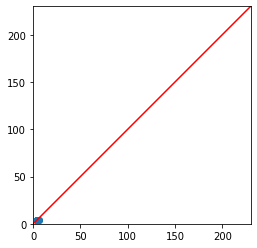

In [ ]:
plt.scatter(y_val, lr.predict(X_val))
plt.xlim(0, 230)
plt.ylim(0, 230)
plt.gca().set_aspect('equal', adjustable='box')
ax = plt.axes()
x = np.linspace(0, 230, 2000)
ax.plot(x, x, 'r');

## RF

In [ ]:
rf_model = RandomForestRegressor( )
rf_cv = cross_validate(rf_model, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (rf_cv['test_score'].mean(), rf_cv['test_score'].std() * 2))

Accuracy: 0.88 (+/- 0.02)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     rf_model = RandomForestRegressor( )
     rf_model.fit(X_train, y_train)
     y_pred = rf_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, rf_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
     features_importance.append(rf_model.feature_importances_)
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2)

Accuracy of test r2: 0.89 (+/- 0.02)
Accuracy of train r2: 0.98 (+/- 0.00)
Accuracy of RMSE: 101.86 (+/- 14.61)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
y_list = [Y1, Y2, Y3, Y4, Y5, Y6]
for y in y_list:
  for train_index, test_index in tscv.split(X):
      y = np.ravel(y)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      rf_model = RandomForestRegressor( )
      rf_model.fit(X_train, y_train)
      y_pred = rf_model.predict(X_test)
      scores.append(r2_score(y_test, y_pred))
      train_scores.append(r2_score(y_train, rf_model.predict(X_train)))
      RMSE.append(mean_squared_error(y_test, y_pred))
      features_importance.append(rf_model.feature_importances_)
  print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
  print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
  print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.97 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 0.80 (+/- 0.45)
Accuracy of test r2: 0.97 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 119370.90 (+/- 243142.14)
Accuracy of test r2: 0.97 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 79580.80 (+/- 228206.23)
Accuracy of test r2: 0.98 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 198592.16 (+/- 470238.18)
Accuracy of test r2: 0.97 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 158873.85 (+/- 449599.68)
Accuracy of test r2: 0.98 (+/- 0.02)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 426463.15 (+/- 1352841.80)


In [ ]:
features_importance = np.array(features_importance)
feature_mean = features_importance.mean(axis = 0)
print(feature_mean)
value_rf = [feature_mean[i] for i in np.where(feature_mean > 0.00145)]
print(value_rf)
index_rf = np.where(feature_mean > 0.00145)
print(index_rf)
sorted_array = sorted(enumerate(feature_mean), key=lambda x:x[1], reverse = True)
print(sorted_array)

[1.20800206e-04 5.47325082e-05 5.12885176e-05 4.73532162e-05
 1.40228190e-05 3.25168324e-05 2.70608724e-05 1.97113676e-03
 4.35191985e-04 5.96631416e-03 1.91519436e-04 1.93565284e-04
 6.75678140e-05 7.09206595e-05 6.07742563e-05 7.43587599e-05
 8.51804110e-05 4.90926222e-05 6.42653762e-05 7.63685104e-05
 4.01946529e-05 5.37296296e-05 5.61566290e-05 7.82724137e-05
 6.64986214e-05 6.16826078e-05 1.53648726e-04 7.78747639e-05
 4.11452777e-05 3.00101444e-05 9.69600648e-05 6.40247220e-05
 6.39401299e-05 7.44871061e-05 6.51305603e-05 8.07328469e-05
 6.26538892e-05 7.04622611e-05 7.18738069e-05 1.27141887e-04
 7.67111846e-05 6.96747284e-05 8.02122290e-05 3.66126003e-05
 6.27283175e-05 5.14201463e-02 7.32038283e-04 4.07624195e-04
 1.61453538e-04 1.56533597e-01 8.99433692e-04 2.95804904e-04
 1.73915462e-04 2.31529933e-01 8.87130271e-04 3.92768958e-04
 1.75343205e-04 4.32677480e-02 8.09438381e-04 1.64679157e-04
 1.35991934e-04 1.36353913e-01 6.30312503e-04 5.81990315e-04
 1.78242017e-04 2.777199

In [ ]:
rf_features = []
for i in importantFeature:
  rf_features.append(features[i])
print(rf_features) 

In [ ]:
rf_cv['test_score']

array([0.8312316 , 0.81280375, 0.79614767, 0.79981299, 0.60999171,
       0.83672879, 0.83313079, 0.8592664 , 0.85109498, 0.83036302])

## Boosting

In [ ]:
# treet boosing
boosting_model = GradientBoostingRegressor(max_depth=10)
clf = Pipeline([
  ('regression', GradientBoostingRegressor(max_depth=8))
])
boosting_cv = cross_validate(clf, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (boosting_cv['test_score'].mean(), boosting_cv['test_score'].std() * 2))

Accuracy: 0.89 (+/- 0.02)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     rf_model = GradientBoostingRegressor(max_depth=4, n_estimators=200)
     rf_model.fit(X_train, y_train)
     y_pred = rf_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, rf_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
     features_importance.append(rf_model.feature_importances_)
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.90 (+/- 0.02)
Accuracy of train r2: 0.95 (+/- 0.00)
Accuracy of RMSE: 90.71 (+/- 13.17)


In [ ]:
features_importance = np.array(features_importance)
feature_mean = features_importance.mean(axis = 0)
print(feature_mean)
value_rf = [feature_mean[i] for i in np.where(feature_mean > 0.00145)]
print(value_rf)
index_rf = np.where(feature_mean > 0.00145)
print(index_rf)
sorted_array = sorted(enumerate(feature_mean), key=lambda x:x[1], reverse = True)
print(sorted_array)

[1.46842573e-03 7.55102581e-04 1.29401763e-03 1.08616992e-03
 6.82160929e-04 2.57049234e-04 1.33271707e-03 1.89970148e-03
 1.08786870e-03 6.32129354e-04 8.09193673e-04 8.89601984e-04
 1.71619350e-03 1.49503649e-03 1.04880280e-03 1.12011392e-03
 1.28065936e-03 1.27394234e-03 8.39430104e-04 1.40123757e-03
 9.32500120e-01 6.24066927e-03 1.09293205e-03 5.49256127e-04
 5.58617559e-04 5.54382453e-04 5.60908757e-04 2.74313504e-03
 6.07088642e-03 9.53933943e-04 1.42374976e-03 7.81207934e-04
 7.60678276e-04 6.71513217e-04 6.87787061e-04 1.43938533e-03
 8.22751760e-04 1.03331517e-03 9.08583315e-04 8.03027259e-04
 9.45993319e-04 7.85428098e-04 7.99165022e-04 8.84259606e-04
 8.02136357e-04 1.21622929e-03 8.54486910e-04 8.26113353e-04
 5.57106475e-04 1.19787871e-03 3.77937507e-03 3.82543302e-03]
[array([0.00146843, 0.0018997 , 0.00171619, 0.00149504, 0.93250012,
       0.00624067, 0.00274314, 0.00607089, 0.00377938, 0.00382543])]
(array([ 0,  7, 12, 13, 20, 21, 27, 28, 50, 51]),)
[(20, 0.9325001197

In [ ]:
boosting_model = GradientBoostingRegressor(max_depth=10)
boosting_cv_time = cross_validate(boosting_model, X, Y, cv=TimeSeriesSplit(n_splits=10), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (boosting_cv_time['test_score'].mean(), boosting_cv_time['test_score'].std() * 2))

Accuracy: 0.72 (+/- 0.21)


In [ ]:
b = boosting_cv['regression'].feature_importances_
idx = [a[i] for i in np.where(a > 0.03)]
print(idx)

NotFittedError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


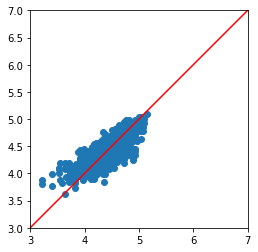

In [ ]:
plt.scatter(y_val, boosting_model.predict(X_val))
plt.xlim(3, 7)
plt.ylim(3, 7)
plt.gca().set_aspect('equal', adjustable='box')
ax = plt.axes()
x = np.linspace(0, 230, 2000)
ax.plot(x, x, 'r');

## XGboost (extreme gradient boosting tree)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     dtrain = xgb.DMatrix(X_train, label=y_train)
     dtest = xgb.DMatrix(X_test)
     param = {'max_depth': 8, 'eta': 0.5}
     bst = xgb.train(params = param, dtrain = dtrain, num_boost_round=10)
     y_pred = bst.predict(dtest)
     scores.append(r2_score(y_test, y_pred))
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))


Accuracy: 0.88 (+/- 0.02)


In [ ]:
import xgboost as xgb
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     dtrain = xgb.DMatrix(X_train, label=y_train)
     dtest = xgb.DMatrix(X_test)
     xgb_model = xgb.XGBRegressor(max_depth=7, objective= 'reg:squarederror', booster= 'gbtree', n_estimators=270, learning_rate= 0.075, subsample= 0.8, min_child_weight= 8, colsample_bytree= 0.825)
     xgb_model.fit(X_train, y_train)
     y_pred = xgb_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, rf_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
     features_importance.append(xgb_model.feature_importances_)
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.90 (+/- 0.02)
Accuracy of train r2: 0.98 (+/- 0.01)
Accuracy of RMSE: 92.67 (+/- 11.27)


In [ ]:
features_importance = np.array(features_importance)
feature_mean = features_importance.mean(axis = 0)
print(feature_mean)
value_rf = [feature_mean[i] for i in np.where(feature_mean > 0.00145)]
print(value_rf)
index_rf = np.where(feature_mean > 0.00145)
print(index_rf)
sorted_array = sorted(enumerate(feature_mean), key=lambda x:x[1], reverse = True)
print(sorted_array)

[0.01594155 0.01348253 0.00391135 0.00489009 0.00789051 0.00379996
 0.00536719 0.00441351 0.00584163 0.03251223 0.00386636 0.00396324
 0.00682448 0.00862695 0.00355906 0.00472092 0.00337861 0.00376288
 0.00331633 0.00368751 0.2916997  0.10263332 0.28495792 0.00340701
 0.00382276 0.00317308 0.00920701 0.01417018 0.0178083  0.00963703
 0.01210564 0.00885202 0.00381553 0.00664122 0.00355781 0.0031764
 0.00471706 0.00307991 0.00311308 0.00347015 0.00486319 0.00473229
 0.00323393 0.00383908 0.00532746 0.0028676  0.00333165 0.00326774
 0.00339536 0.00930631 0.00917425 0.00985917]
[array([0.01594155, 0.01348253, 0.00391135, 0.00489009, 0.00789051,
       0.00379996, 0.00536719, 0.00441351, 0.00584163, 0.03251223,
       0.00386636, 0.00396324, 0.00682448, 0.00862695, 0.00355906,
       0.00472092, 0.00337861, 0.00376288, 0.00331633, 0.00368751,
       0.2916997 , 0.10263332, 0.28495792, 0.00340701, 0.00382276,
       0.00317308, 0.00920701, 0.01417018, 0.0178083 , 0.00963703,
       0.0121056

## knn regression

In [ ]:
# knn regression
knn = neighbors.KNeighborsRegressor(2)
knn_cv = cross_validate(knn, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (knn_cv['test_score'].mean(), knn_cv['test_score'].std() * 2))

Accuracy: 0.84 (+/- 0.03)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     knn_model = neighbors.KNeighborsRegressor(2)
     knn_model.fit(X_train, y_train)
     y_pred = knn_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, knn_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.83 (+/- 0.03)
Accuracy of train r2: 0.94 (+/- 0.00)
Accuracy of RMSE: 152.28 (+/- 22.76)


In [ ]:
knn_cv['test_score']

array([-0.38390945, -0.00849499, -0.23657244, -0.21057404, -0.26483155,
        0.13391867,  0.17037083, -0.08668692, -0.4680151 , -0.8249952 ])

## svm regression

In [ ]:
# svm regression
svr = SVR(C=10)
svr_cv = cross_validate(svr, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (svr_cv['test_score'].mean(), svr_cv['test_score'].std() * 2))

Accuracy: 0.87 (+/- 0.02)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     svr_model = SVR(C=20)
     svr_model.fit(X_train, y_train)
     y_pred = svr_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, svr_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
     features_importance.append(svr_model.dual_coef_)
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.89 (+/- 0.02)
Accuracy of train r2: 0.92 (+/- 0.00)
Accuracy of RMSE: 98.02 (+/- 13.83)


In [ ]:

feature_mean = features_importance.mean(axis = 0)
print(feature_mean)
value_rf = [feature_mean[i] for i in np.where(feature_mean > 0.00145)]
print(value_rf)
index_rf = np.where(feature_mean > 0.00145)
print(index_rf)
sorted_array = sorted(enumerate(feature_mean), key=lambda x:x[1], reverse = True)
print(sorted_array)

AttributeError: ignored

In [ ]:
svr.dual_coef_

array([[ 6.22353262, -0.40050309, -0.21649348, ..., 13.96313361,
        -0.13578592,  0.07948564]])

## Neural network

In [ ]:
# neural network
DNN = MLPRegressor(hidden_layer_sizes=(50,50,50,30,30,30,30,10), activation='tanh', early_stopping=True, batch_size=50, max_iter=1000, verbose=False)
DNN_cv = cross_validate(DNN, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (DNN_cv['test_score'].mean(), DNN_cv['test_score'].std() * 2))

Accuracy: 0.25 (+/- 0.79)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     MLP_model = MLPRegressor(hidden_layer_sizes=(128,64,64,64,32,32,32,32,16,16), activation='relu', early_stopping=True, batch_size=400, max_iter=1000, verbose=False)
     MLP_model.fit(X_train, y_train)
     y_pred = MLP_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, MLP_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.89 (+/- 0.02)
Accuracy of train r2: 0.92 (+/- 0.01)
Accuracy of RMSE: 100.44 (+/- 17.13)


In [ ]:
plt.scatter(y_val, y_pred)
plt.xlim(3, 7)
plt.ylim(3, 7)
plt.gca().set_aspect('equal', adjustable='box')
ax = plt.axes()
x = np.linspace(0, 230, 2000)
ax.plot(x, x, 'r');

NameError: ignored

In [ ]:
# Regression Example With Boston Dataset: Standardized and Larger
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# load dataset

# define the model
def larger_model():
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=40, kernel_initializer='normal', activation='relu'))
	model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger: -0.19 (0.11) MSE


dict_keys(['val_loss', 'loss'])


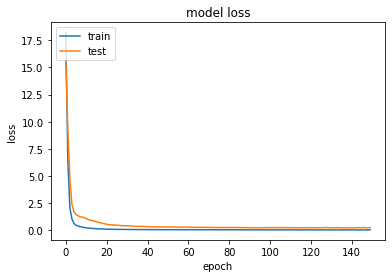

In [ ]:
model = larger_model()
history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred  = model.predict(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


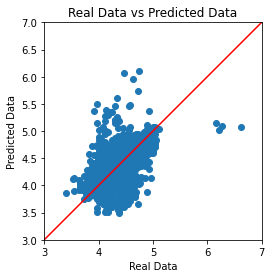

In [ ]:
plt.scatter(Y, y_pred)
plt.title('Real Data vs Predicted Data')
plt.xlabel('Real Data')
plt.ylabel('Predicted Data')
plt.xlim(3, 7)
plt.ylim(3, 7)
plt.gca().set_aspect('equal', adjustable='box')
ax = plt.axes()
x = np.linspace(0, 230, 2000)
ax.plot(x, x, 'r');
plt.show()